<img src = "bgsedsc_0.jpg">
$\newcommand{\bb}{\boldsymbol{\beta}}$
$\DeclareMathOperator{\Gau}{\mathcal{N}}$
$\newcommand{\bphi}{\boldsymbol \phi}$
$\newcommand{\bpi}{\boldsymbol \pi}$
$\newcommand{\bx}{\boldsymbol{x}}$
$\newcommand{\by}{\boldsymbol{y}}$
$\newcommand{\bmu}{\boldsymbol{\mu}}$
$\newcommand{\bS}{\boldsymbol{\Sigma}}$
$\newcommand{\whbb}{\widehat{\bb}}$
$\newcommand{\hf}{\hat{f}}$
$\newcommand{\hy}{\hat{y}}$
$\newcommand{\tf}{\tilde{f}}$
$\newcommand{\ybar}{\overline{y}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\Var}{Var}$
$\newcommand{\Cov}{Cov}$
$\newcommand{\Cor}{Cor}$

# Classification

In some ways there is very little to say about classification: it is like regression but with categorical response. As before there will be a learning function $f(\bx)$ but now the model that relates it to the response has to change to reflect the different characteristics thereof. But we can use the same set of tools - loss functions will change and as a result our tools of measuring performance too. 

On the other hand, this is a very common prediction problem and it is worth to understand deeper some of its intricacies

We will start with binary classification - the response is one of two categories. The labelling of the categories is arbitrary and any sensible methodology should not rely on how these categories are coded numerically. We will stick to 0/1 coding for the two categories. This is mathematically more convenient for the methods we will use here. For other approaches to classification -1/1 might be more convenient. 


## Summary

In this module we build predictive models for categorical outputs, following the same paradigm as in regression but changing the distribution that relates the output $y$ to the learning function $f(\bx)$. We also adapt appropriately the model performance criteria and introduce concepts such as the misclassification probability, the ROC curve and AUC score. We discuss the problem of class imbalance and some solutions. We show how to predict multicategorical and ordinal output in a simple framework.

## The spam dataset

This is a classic dataset for binary classification, it can be found in the UCI repository

http://www.ics.uci.edu/~mlearn/MLRepository.html

and it is analyzed in few different ways in the Hastie et al. book 

I have created a version with a subset of the variables

In [1]:
import pandas as pd
%matplotlib inline
import numpy as np
# This is a Python module that contains plotting commands
import matplotlib.pyplot as plt
# the following provides further tools for plotting with dfs
import seaborn as sns 

/Users/polinab/.virtualenvs/base/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
#subset initial dataset to last n columns, first 100 rows
spam = pd.read_csv("../data/spambase_csv.csv").iloc[:, 50:][:5000]
spam.head()

,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.0,0.135,0.000,0.000,3.537,40,191,1


<AxesSubplot:>

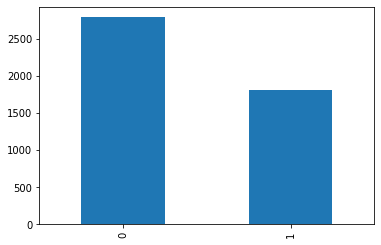

In [3]:
# Lets explore some basic aspects of this dataset

spam["class"].value_counts().plot(kind="bar")

0         AxesSubplot(0.1,0.15;0.363636x0.75)
1    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

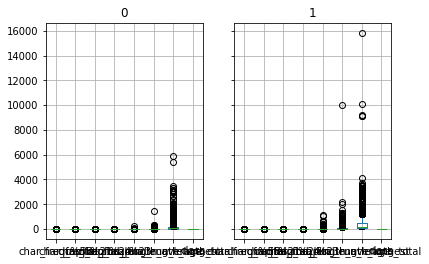

In [4]:
spam.groupby("class").boxplot()

In [5]:
# recall that

spam.columns

Index(['char_freq_%5B', 'char_freq_%21', 'char_freq_%24', 'char_freq_%23',
       'capital_run_length_average', 'capital_run_length_longest',
       'capital_run_length_total', 'class'],
      dtype='object')

The previous exploratory analysis is analogous to screening by correlations in regression. We could for example test nonparametrically equality of the two distributions - although these are only assessing marginal dependence and not interactions 

## Probabilistic classification using logistic regression

We will follow a very analogous route to regression. There will be a learning function and we will take to be linear in parameters and features: 

$$ f(\bx_i,\bb) = \bb^T \bphi_i$$

We will also model the distribution of the response and relate this distribution to the linear predictor

There is no assumptions in this case for the distribution of the response: there is only one distribution to describe binary variables, the *Bernoulli*. Our probabilistic binary classification models take: 

$$ y_i \sim Bernoulli(\pi_i) \iff p(y_i=1) = \pi_i \quad p(y_i=0) = 1-\pi_i$$

The remaining assumption we will make is how to relate $\pi_i$ to the linear predictor. We basically need a transformation that maps real values to $[0,1]$. The *logistic transformation* is one option and leads to the so-called **logistic regression**:

\begin{equation}
y_i \sim Bernoulli\left({1 \over 1 + e^{-f(\bx_i,\bb)}}\right)
\end{equation}

The function that maps $f(\bx_i,\bb)$ to $\pi_i$ is shown below: 

<img src="480px-Logistic-curve.png" width = 300>

Basic math shows that in this model 

$$- \log p(y_i | \bx_i) =  \log (1+e^{-f(\bx_i,\bb)}) + y_i f(\bx_i,\bb) $$ 

hence, the loss function becomes 

$$L(\bb) = \sum_i \log (1+e^{-f(\bx_i,\bb)}) + y_i f(\bx_i,\bb) $$

This is also **convex** and can be optimized efficiently (this true for other *link* functions too, e.g. probit). A standard way to do this is using Fisher scoring, a variation of Newton-Raphson - these are **gradient-descent iterative optimization algorithms**. These work in the same way for the whole family of **generalized linear models**


We now fit the model to the spam dataset. For the moment we will use the original variables as features

Here we focus on predictive modelling and the `LogisticRegression` is reasonable. For inference this is not providing enough detail. This function actually optimizes over a penalized likelihood loss function, the default being a rigde penalty. We will set the regularization parameter to a very small value to keep its effect minimal for the time being ($n$ here is very large relative to $p$)

Note that unlike `LinearRegression` now we can feed the function with dfs and series... 

In [6]:

F = spam.drop('class', axis = 1)
y = spam["class"]

# to print stats
feature_names = F.columns
class_labels = ["email","spam"] # meant to represent 0 and 1

In [7]:
# importing the relevant sklearn tools
from sklearn.linear_model import LogisticRegression

lregr = LogisticRegression(penalty='l2', C=100.0, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           solver='liblinear', max_iter=500)

# Fiting logistic regression

lregr.fit(F,y)      

# Compute the predicted probabilities in-sample

insample_pred = lregr.predict_proba(F)

insample_pred_res = spam.copy()

insample_pred_res["pi_i"] = insample_pred[:,1]

print(insample_pred_res.iloc[1:15,-1])

1     0.913018
2     0.999691
3     0.280454
4     0.279907
5     0.178868
6     0.282437
7     0.167294
8     0.999427
9     0.525047
10    0.249381
11    0.322685
12    0.562978
13    0.157040
14    0.281502
Name: pi_i, dtype: float64


<AxesSubplot:title={'center':'pi_i'}, xlabel='class'>

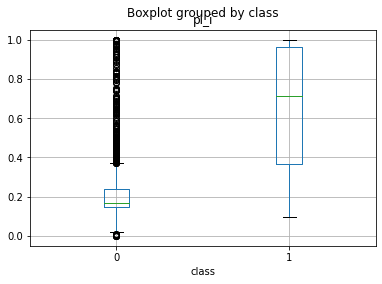

In [8]:
# lets see more globally the fitted probs

insample_pred_res.boxplot(column="pi_i",by="class")

## Turning probabilities into class prediction

The *probabilistic classifier* we use explicitly accounts for misclassification errors. The algorithm returns probabilities and these also reflect the classification uncertainty

Recall that if $y \sim Bernoulli(\pi)$ then $\Var(y) = \pi (1- \pi)$, which is large for $\pi \approx 1/2$

Often this is all one needs to have to do sensible data analysis - the probabilities (*see advanced material for details*)




In other contexts it might be of interest to turn probabilities into class predictions, $\hy_i \in \{0,1\}$, e.g., to report medical tests (pregnant/no pregnant) - the spam example is also a good example: a decision has to be taken for each email and it is convenient to have the algorithm produce class predictions. We will denote those by $\hy_i$

With class prediction there will be **misclassification errors**: false positives and false negatives

Before we go into details, lets see what the default operations in `sklearn` do for us. We can compute the following quantities in or out of sample and cross-validated too - basically all the discussion about use of sample for evaluation for regression applies here too. For the moment we experiment with in-sample calculations

In [9]:
# this is the predict method in the LogisticRegression object
y_hat = lregr.predict(F)
y_hat[0:10]

array([1, 1, 1, 0, 0, 0, 0, 0, 1, 1])

[[2651  137]
 [ 627 1186]]


<AxesSubplot:>

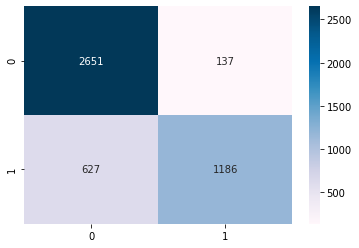

In [10]:
from sklearn.metrics import confusion_matrix

#confusion matrix
cm =  confusion_matrix(y_pred=y_hat, y_true=y, labels=[0,1])
print(cm)
# Plotting confusion matrix (custom help function)
sns.heatmap(cm,annot=True,fmt="d",cmap="PuBu")


What `.predict` has done is the following: if $\pi_i \geq 1/2$ it sets $\hy_i = 1$. This is verified below: 

In [11]:
insample_pred

array([[4.38893207e-01, 5.61106793e-01],
       [8.69821112e-02, 9.13017889e-01],
       [3.08983502e-04, 9.99691016e-01],
       ...,
       [8.47100893e-01, 1.52899107e-01],
       [8.50938455e-01, 1.49061545e-01],
       [8.28202407e-01, 1.71797593e-01]])

[[2651  137]
 [ 627 1186]]


<AxesSubplot:>

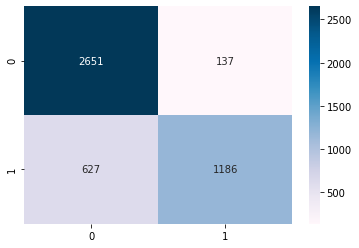

In [12]:
y_hat_new = np.ones(y.size)
y_hat_new[insample_pred[:,1] <0.5] = 0
#confusion matrix

cm =  confusion_matrix(y_pred=y_hat_new, y_true=y, labels=[0,1])
print (cm)
# Plotting confusion matrix 
sns.heatmap(cm,annot=True,fmt="d",cmap="PuBu")


Depending on the application the losses can be very different (remember the medical example). Let 

$$L(true,predict)$$ 

be a loss function that computes the cost of misclassification - this is something that requires context information not in the data. We take 

$$L(0,0) = L(1,1) = 0 \quad L(1,0) > 0 \quad L(0,1) > 0$$

Little math shows that if $L(1,0)/L(0,1) = C$ the optimal decision is: 

$$\hy_i = 1 \iff \pi_i > {1 \over 1+C}$$

### Misclassification rate

$$p[ y \neq \hy]$$ 

is known as the misclassification probability. This can be estimated from data very much the same way as $R^2$: in sample (which can be negatively biased), out of sample (which is data intensive), by cross-validation etc; also by using more advanced math, such as *concentration inequalities*

This number in isolation means pretty much nothing. Consider or example the (all too common situation) where we wish to predict $y$ in a population such that $p[y=1] = 0.001$. Then classifying everyone as $\hy = 0$ yields a misclassification probability 0.001 but the algorithm is never able to identify the class of interest. Missclassification rate can be useful in comparisons. 

There are other performance metrics - related to conditional probabilities - e.g. $p[\hy =1 | y=1]$ etc - such as specificity/sensitivity for qualifying the performance of a classifier

### ROC curve and AUC

A common tool to assess the performance of a probabilistic classifier is the ROC curve. Each point on this curve is (an estimate of) pair

$$
(p([\hy = 1 | y = 0] , p[\hy =1 | y = 1]) 
$$

For a given threshold $t$ we can estimate these probabilities from the confusion matrix - obtained in the best way we can - simply by computing the associated frequencies

As we vary the threshold the confusion matrices change and the frequencies too: varying $t$ from 0 to 1 we obtain the ROC curve - read the figure from right to left

We do this now using a customized function. I will do it on a test spam data


0.8994644331034984


[Text(0.5, 0, 'False Positive Rate'), Text(0, 0.5, 'True Positive Rate')]

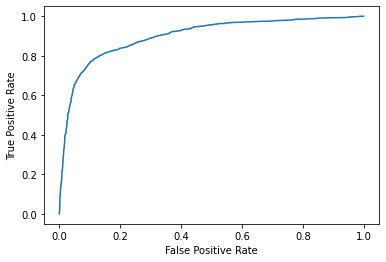

In [13]:
# read the test data, extract the info and create predictions
from sklearn import metrics
import scikitplot as skplt
import matplotlib.pyplot as plt


spam_test = pd.read_csv("../data/spambase_csv.csv").iloc[:, 50:]
Ftest = spam_test.drop("class",axis=1)
ytest = spam_test["class"]
test_pred_proba = lregr.predict_proba(Ftest)[:,1]
test_pred_label = [1 if x > 0.5 else 1 for x in test_pred_proba]

fpr, tpr, thresholds = metrics.roc_curve(ytest.values, test_pred_proba, pos_label=1)

# # Custom plot function
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

sns.lineplot(x=fpr,y=tpr).set(xlabel="False Positive Rate"
                              , ylabel = "True Positive Rate")


AUC is the Area Under (the ROC) Curve

It has though an interesting and solid statistical interpretation. It can be directly related to a non-parametric test - the **Mann-Whitney** that the following two samples come from the same distribution: 

$$
\textrm{class 1 probs }: \{\pi_i: y_i = 1\} \quad \textrm{class 0 probs }: \{\pi_i: y_i = 0\}
$$

You would expect that for a decent classifier the two samples come from different distributions and the distribution of the "class 1 probs" is stochastically greater. If the two distributions were identical we would obtain the green-dashed ROC curve.

Consider a contest between the two samples:  each element of the first we compare with all of the elements in the second and record how many times it was at least as big. AUC is the frequency of won contests!

For some `sklearn` tools check 

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

### Exercise
As a sanity check, draw the curve for estimates using in-sample predictions.

What do expect in-sample AUC to be, higher or lower than out-of-sample AUC? 

0.88223495786521


[Text(0.5, 0, 'False Positive Rate'), Text(0, 0.5, 'True Positive Rate')]

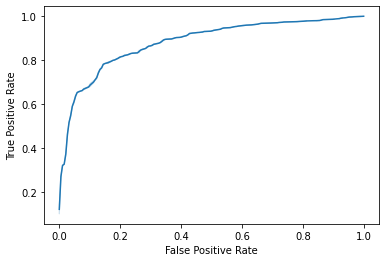

In [14]:
# Here I used a smaller sample, with a lower score
spam_test = pd.read_csv("../data/spambase_csv.csv").iloc[:, 50:][:2000]
Ftest = spam_test.drop("class",axis=1)
ytest = spam_test["class"]
test_pred_proba = lregr.predict_proba(Ftest)[:,1]
test_pred_label = [1 if x > 0.5 else 1 for x in test_pred_proba]

fpr, tpr, thresholds = metrics.roc_curve(ytest.values, test_pred_proba, pos_label=1)

# # Custom plot function
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

sns.lineplot(x=fpr,y=tpr).set(xlabel="False Positive Rate"
                              , ylabel = "True Positive Rate")

## Class imbalance

### Context

Typically, we want to predict the incidence of a rare event:  rare disease, an accident, a default, exceptional performance, etc, on the basis of measured characteristics. 

If we collect data *prospectively* we will end up with a sample with very little representation of the class we are particularly interested in. Hence it will be hard to learn the function that separates "rare" from "common" on the basis of the measured characteristics; indeed classifiers will not mind overpredicting the "common". 

Lets look at an example first

### Can we predict good wine ? 

This is another standard dataset available from the UCI repository. It is really about **ordinal regression** - or maybe **multiclass classification**. Here we will for illustration consider (at the expense of losing information) a transformation of the response 


In [15]:
wine_df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=';')
# wine_df = pd.read_csv("wine.csv")

In [16]:
wine_df.sample(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
499,8.7,0.690,0.31,3.0,0.086,23.0,81.0,1.00020,3.48,0.74,11.6,6
923,6.8,0.410,0.31,8.8,0.084,26.0,45.0,0.99824,3.38,0.64,10.1,6
559,13.0,0.470,0.49,4.3,0.085,6.0,47.0,1.00210,3.30,0.68,12.7,6
898,8.3,0.310,0.39,2.4,0.078,17.0,43.0,0.99444,3.31,0.77,12.5,7
136,8.3,0.715,0.15,1.8,0.089,10.0,52.0,0.99680,3.23,0.77,9.5,5


<AxesSubplot:>

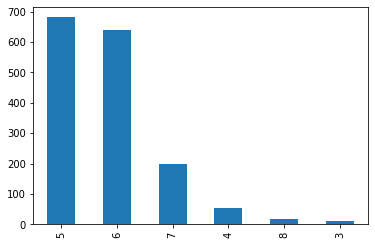

In [17]:
wine_df.quality.value_counts().plot(kind="bar")

In [18]:
wine_df['quality'] = [1 if q >= 8 else 0 for q in wine_df.quality ]

<AxesSubplot:>

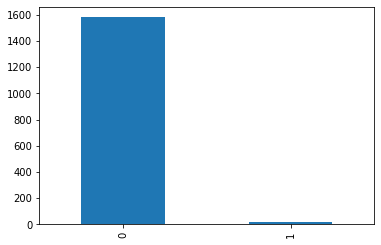

In [19]:
wine_df.quality.value_counts().plot(kind="bar")


In [20]:
wine_df.quality.value_counts()

0    1581
1      18
Name: quality, dtype: int64

This is class imbalance for you!

In [21]:
# prepare the data
X = wine_df.drop('quality', axis =1)
y = wine_df.quality


In [39]:
from sklearn.model_selection import cross_val_predict

# I should have standardised features but here I am using tiny regularisation so it should not matter
model = LogisticRegression(C=100, solver='liblinear') 
y_pred = cross_val_predict(model, X, y, cv = 5)
model.fit(X,y)
y_prob = model.predict_proba(X)

0.9185114906177525


[Text(0.5, 0, 'False Positive Rate'), Text(0, 0.5, 'True Positive Rate')]

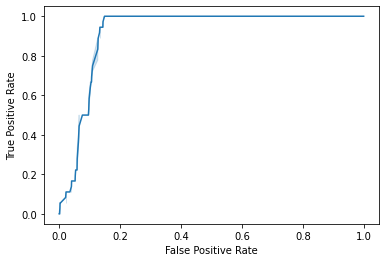

In [40]:
# AUC
y_probabilities = cross_val_predict(model, X, y, method='predict_proba', cv = 5)
y_probabilities[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y.values, y_probabilities[:,1], pos_label=1)

# # Custom plot function
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

sns.lineplot(x=fpr,y=tpr).set(xlabel="False Positive Rate"
                              , ylabel = "True Positive Rate")
# # get_auc(y, y_probabilities, ["Bad/Average Wine", "Great Wine"], column=1, plot=True) # Help function


In [24]:
#### Accuracy
from sklearn.metrics import accuracy_score


print ("Accuracy (cross-validated): ", accuracy_score(y, y_pred))

####  Classification report
from sklearn.metrics import classification_report

print (classification_report(y, y_pred))

Accuracy (cross-validated):  0.9868667917448405
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1581
           1       0.00      0.00      0.00        18

    accuracy                           0.99      1599
   macro avg       0.49      0.50      0.50      1599
weighted avg       0.98      0.99      0.98      1599



**The operation was successful but the patient died!**

#### Exercise
Plot the confustion matrix to verify results. Are we predicting the 'good wines'?

[[1581    0]
 [  18    0]]


<AxesSubplot:>

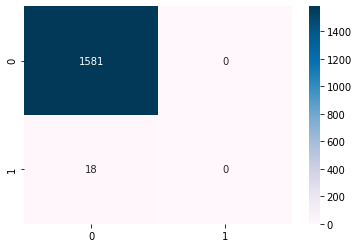

In [41]:
#Your code here
cm =  confusion_matrix(y_pred=y_pred, y_true=y, labels=[0,1])
print (cm)
# Plotting confusion matrix 
sns.heatmap(cm,annot=True,fmt="d",cmap="PuBu")



## Some approaches to class imbalance

Roughly speaking there are two ways to try and do better: 

+ Retrospective study & bias correction: this operates at the *experimental design* stage, that is the way data are collected in the first place 

+ Resampling and use of synthetic data (& bias correction): this works with the data at hand

### Retrospective studies

Collect data not as a *representative* sample from the population of interest, but oversample the rare class; for example from your medical database choose a sample of $n/2$ patients with the rare disease and $n/2$ without

On the basis of this *biased (non-representative)* sample train a probabilistic classifier, e.g., logistic regression 

The estimated learning function is biased too - it will predict way larger probability of class=1 

There are at least two ways to do proper inference with the non-representative sample. 

Lets say that $q(y)$ are the probabilities of the two classes in the population of interest, i.e., $q(1), q(0)$. And $r(y)$ are the probabilities with which we have sampled 

+ One is to change the loss function: instead of using the log-likelihood, which is an *arithmetic average* of individual log-densities, use a *weighted average*

  Some math shows that the following is a valid choice: 
  
  $$ L(\bb) = \sum_i {q(y_i) \over r(y_i)} \left [\log (1+e^{-f(\bx_i,\bb)}) + y_i f(\bx_i,\bb)\right ] $$
  
+ Another is to run the analysis with the biased sample and the log-likelihood loss, but then rescale the estimated probabilities

  Some math shows that if $\pi(y_i)$ are the probabilities estimated by the model, they should be changed to 
  
  $$ { \pi(y_i) {q(y_i) \over r(y_i)} \over \pi(1) {q(1) \over r(1)} + \pi(0) {q(0) \over r(0)}}$$
  
  Lets understand what is the effect of this weighting: consider very small and very large predicted $\pi_i$
  
Both approaches require that $q(y)$ is known - but this is often easy enough 

### Resampling approaches

Having no control of the data collection protocol, one can try and sharpen the distinction between the two classes by either under-representing (*undersampling*) the popular class, or over-representing (*oversampling*) the rare class, or both

Oversampling might just be randomly replicating rare cases or creating synthetic rare cases that "look like" the rare cases in the sample. To this respect doing some modelling on the $\bx_i$s can help - and there are links to *Bayes classifiers* we mention later. For example SMOTE (Synthetic Minority Oversampling Technique) does this

Any of these approaches needs to be combined with one of the bias-correction approaches developed above

Some tools in `sklearn` to do this are, e.g., the module `imblearn` and its methods `.over_sampling`, e.g. `RandomOverSampler` and `SMOTE`. `imblearn` requires installing - do not do this now! Analogous result to `.over_sampling` is obtained using `LogisticRegression`  `class_weight="balanced"` argument, that corresponds to oversampling

In our wine prediction example we have also done some arbitrary dichotomization of the response: no good reason why we should not pay for it!!

Lets try this one for the wine data:

In [28]:
model = LogisticRegression(C=100, class_weight='balanced', solver='liblinear')
model.fit(X,y)
y_prob_imb = model.predict_proba(X)
wine_df_original = wine_df
wine_df_original["pred_prob"] = y_prob[:,1] 
wine_df_original["pred_prob_imb"] = y_prob_imb[:,1]

Note that these are not proper estimates of the class probability: we need to correct for the biased sample by rescaling the predicted probability 

In [29]:
## the correction factor: 

q1 = y.sum()/len(y)
r1 = 0.5

def reweight(pi,q1=0.5,r1=0.5):
    r0 = 1-r1
    q0 = 1-q1
    tot = pi*(q1/r1)+(1-pi)*(q0/r0)
    w = pi*(q1/r1)
    w /= tot
    return w

In [30]:
# correcting for biased sample

wine_df_original["pred_prob_imb_corr"] = wine_df_original["pred_prob_imb"].apply(reweight,args=(q1,r1))

array([<AxesSubplot:title={'center':'pred_prob'}, xlabel='quality'>,
       <AxesSubplot:title={'center':'pred_prob_imb'}, xlabel='quality'>,
       <AxesSubplot:title={'center':'pred_prob_imb_corr'}, xlabel='quality'>],
      dtype=object)

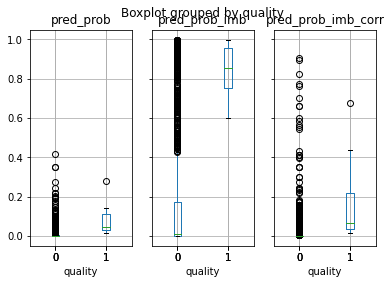

In [31]:
 
wine_df_original.boxplot(["pred_prob","pred_prob_imb","pred_prob_imb_corr"],by="quality",layout=(1,3))

[[1568   13]
 [  17    1]]


<AxesSubplot:>

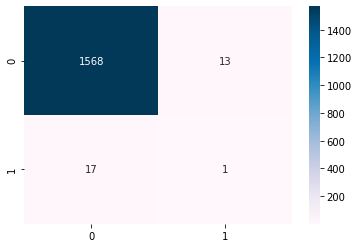

In [35]:
y_pred_new = [1 if pi >= 0.5 else 0 for pi in wine_df_original["pred_prob_imb_corr"] ]

cm =  confusion_matrix(y_pred=y_pred_new, y_true=y, labels=[0,1])
print (cm)
# Plotting confusion matrix 
sns.heatmap(cm,annot=True,fmt="d",cmap="PuBu")


## Regularization

Everything that applies to regression applies to logistic regression: ridge, lasso etc penalties can be used for high-dimensional feature spaces and when they are convex the resultant loss function is too and the algorithms are efficient 

Indeed, the `LogisticRegression` function by default includes the penalty

## Multiclass classification

Often the output variable is categorical with many options, not just two, e.g. the wine dataset. 

It is more convenient to encode such multiclass output using the 1-hot encoding, i.e., each output is a vector of 0s with a single 1 in the chosen class: 

$$\by_i = (y_{i1},\ldots,y_{iK})^T \quad y_{ij} \in \{0,1\}, \quad \sum_j y_{ij} = 1$$


where the labels $1,2,\ldots,K$ are arbitrary encodings for the different output categories and any sensible analysis should not depends on their values. 

Binary classification takes $K=2$. In fact, in modern applications $K \sim 100$ or even $K \sim 1000$ (e.g. *recommendation*).

The most direct extension of the binary regression to multiclass is as follows. We take

$$\by_i \sim Categorical(\pi_{i1},\ldots,\pi_{iK})$$

with density 

$$p(\by_i) = \prod_{j} \pi_{ij}^{y_{ij}}$$

which is a clever way to simply say that the probability that the $j$th category is chosen is $\pi_{ij}$. 

### Multinomial-logistic regression

We need to map the probabilities $\pi_{ij}$ to the input $\bx_i$. One way that collapses to logistic regression when $K=2$ is to take:

$$\log{\pi_{ij} \over \pi_{i1}} = f(\bx_i,\bb_j)$$

Note that implicit in this definition is that the odds to choose $j$ vs 1 do not depend on what other options there exist: this is known as the *independence of irrelevant alternatives* assumptions and is criticized in certain contexts. 

The model definition implies

$$\pi_{ij} = {e^{f(\bx_i,\bb_j)} \over 1+ \sum_{k>1} e^{f(\bx_i,\bb_k)}}$$

and you should check that for $K=2$ this is precisely logistic regression. The pivot category is taken above to be 1, but any other can be chosen - this only affects the interpretation of the results. Note also that we have different parameters $\bb_j$ for each category $j$. 

This model is known by a multitude of names...

https://en.wikipedia.org/wiki/Multinomial_logistic_regression

The negative log-likelihood is immediatelly obtained and is **convex** in the $\bb_j$s, hence we have a nice learning problem to solve. In fact, an old clever trick can be used to turn learning this model into a Poisson GLM, this is known as the *Poisson trick* in the Stats community. This is particularly clever for large $K$ and is being reinvented (again..) by the ML community

### Reanalyzing the wine data

`LogisticRegression` in `sklearn` does in fact also fit the multinomial-logistic regression model. Lets try this out

In [50]:
# multinomial-logistic regression for wine
model = LogisticRegression(C=100,multi_class="multinomial",solver="newton-cg",max_iter=10000) 
X = wine_df.drop('quality', axis =1)
y = wine_df.quality
model.fit(X,y)

LogisticRegression(C=100, max_iter=10000, multi_class='multinomial',
                   solver='newton-cg')

In [51]:
y_probabilities = cross_val_predict(model, X, y, method='predict_proba', cv = 5)

In [52]:
def plot_confusion_matrix(cm, class_labels):
    df_cm = pd.DataFrame(cm, index = [i for i in class_labels],
                  columns = [i for i in class_labels])
    sns.set(font_scale=1)
    sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel("Predicted label")
    plt.ylabel("Real label")
    plt.show()

In [55]:
y_pred = cross_val_predict(model, X, y, cv = 5)
cm =  confusion_matrix(y_pred=y_probabilities[:,1], y_true=y, labels=[3,4,5,6,7,8])
# # Plotting confusion matrix (custom help function)
# plot_confusion_matrix(cm, ["3","4","5","6","7","8"]) 
cm

ValueError: Classification metrics can't handle a mix of binary and continuous targets

Notice the shrinkage towards the 5!

## Some hints for the practitioners

+ Predictive modelling with categorical output can be done using `LogisticRegression`; by default this module includes regularization, hence it is straighforward to include hundreds of features
+ When the output is multicategorical is way more sensible to build directly a model for the original output than first turn it (more or less arbitrarily) into a binary output. Even if for commercial/interpretability purposes a binary prediction is preferred, is preferrable to turn the multicategorical prediction into binary rather than the multicategorical output to binary and build a model
+ A probabilistic classifier returns probabilities for the possible categories. It is not the data scientist's job to turn those into class predictions. This should be done in conjunction with the user of the analysis and the consideration of losses. Once the losses have been specified a simple formula gives the optimal conversion
+ Class imbalance is an issue relevant for many or even most classification applications. Using the `class_weight="balanced"` within `LogisticRegression` gives a possible improvement using oversampling - make sure to correct the probabilities it returns since they are not correct!

## Programming project: forest cover classification

In this project, you have to predict the class of forest cover (the predominant kind of tree cover) from strictly cartographic and environment variables.

The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains categorical data for qualitative independent variables (wilderness areas and soil types).

You have further details on the data at *covertype.info* file and at https://archive.ics.uci.edu/ml/datasets/Covertype

Be aware that the final dataset has been slighly modified from the original source data.

As performance metric, you can use *AUC* in the binary classification case. For multi-class classification, check as well the confussion matrix and estimate the misclassification probabilities of different classes(check *metrics.confusion_matrix* and *metrics.classification_report* in *sklearn*).

+ Using *MultiClass_Train.csv* file build a predictive model for *Cover_Type* .
+ Try a first a binary classification to predict class #7 (Krummholz, https://en.wikipedia.org/wiki/Krummholz), which is a rare valuable habitat. After that, then try multi-variate classification to predict all classes.
+ For this analysis there is an extra test dataset. Once your code is submitted we will run a competition to see how you score in the test data. Hence have prepared also the necessary script to compute the accuracy estimate on the test data once released.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Create *dummy variables* for relevant categorical features
3. Reformat the Class_type variable into a binary one, being class #7 the target variable versus the others.
4. *Build* an initial binary model for class #7 versus the other ones and test it on the same input data. Try to improve it using methods to tackle class imbalance.
5. Assess expected accuracy using *cross-validation*
6. Report which variable impacts more on results 
7. Repeat 4., 5., 6. now with a multi-class model
8. Prepare the code to *run* on a new input file and be able to report accuracy, following same preparation steps (missing data, dummies, etc)


In [ ]:
## Your code here (click on the window and type 'b' if you want to split in more than one code window)

# Step 1: Read and explore data


# Step 2: Create dummies for relevant features


# Step 3: Reformat the data to have an binary class target (class #7 is the target to predict)


# Step 4: Build a binary model to predict class #7 (refine considering class imbalance methods)


# Step 5: Assess expected accuracy: AUC


# Step 6: Report variable impact


# Step 7: Repeat 4,5,6 with a multi-class model. 
# As metrics, besides global accuracy, include the estimation of missclassification probabilities by class
# Report accuracies of class #7 compared to the binary model


# Step 8: Prepare code to run and check performance of you model using a new input data with same exact format


## References

Hastie, T., Tibshirani, R., Friedman, J., 2009. *Elements of Statistical Learning*. 2nd Edition. Section 4.4; More advanced 3.8,3.9.  https://web.stanford.edu/~hastie/ElemStatLearn/

Bishop, C.M. *Pattern recognition and machine learning*. Sections 4.2, 4.3